In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# apply some styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

In [3]:
weather_df = pd.read_csv('cleaned_weather.csv')
# read the solar plant generation data
solar_df = pd.read_csv('plant_output.csv')
# drop unused columns
solar_df = solar_df.drop(['Plant', 'Real-time power(kW)', 'Daily feed-in energy(kWh)', 'Energy purchased today(kWh)'], axis=1)

# Both weather and solar df are date aligned
data_df = weather_df
data_df['output'] = solar_df['Daily yield(kWh)']
# Remove entries with known 0 output
data_df = data_df[~(data_df['output'] == 0)]
data_df.drop(data_df.columns[0], axis=1, inplace=True)

/var/folders/zh/nt4cvtjd1bl_ntm3_d6kztf40000gn/T/ipykernel_25615/720678684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.drop(data_df.columns[0], axis=1, inplace=True)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
scaler = StandardScaler()
numeric_cols = data_df.select_dtypes(include=[np.number]).columns
data_df = data_df[numeric_cols]
data_norm = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)
data_norm.head(5)

,tempmax,tempmin,temp,dew,humidity,precip,precipprob,precipcover,cloudcover,solarradiation,solarenergy,solartime,output
0,-1.403946,-0.829721,-1.376138,0.242118,1.004365,-0.293308,-0.6003,-0.451987,-0.883851,-0.680943,-0.651917,-1.509529,-0.281256
1,-0.916350,-1.188969,-1.340224,-0.316047,0.483319,-0.293308,-0.6003,-0.451987,-0.686336,-0.583275,-0.588037,-1.502480,-0.042159
2,-1.322680,-1.787716,-1.735276,-1.127923,0.024799,-0.293308,-0.6003,-0.451987,0.044818,-0.513248,-0.502863,-1.495189,0.017616
3,-1.187236,-2.296651,-2.094413,-1.584603,-0.301724,-0.293308,-0.6003,-0.451987,-0.859595,-0.476393,-0.460277,-1.487654,-0.639903
4,-1.105970,-1.997277,-1.843017,-1.178665,-0.114147,-0.293308,-0.6003,-0.451987,-0.280909,-0.588803,-0.566744,-1.479148,-0.460580


In [5]:
# Split data 
X = data_norm.drop('output', axis=1)
y = data_norm['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
print( 'X ', X.shape)
print( 'y ', y.shape)
print( 'X_train ', X_train.shape)
print( 'y_train ', y_train.shape)

X  (151, 12)
y  (151,)
X_train  (120, 12)
y_train  (120,)


In [6]:
def predict_and_eval(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    tr_mse = mean_squared_error(y_train, y_train_pred)
    tr_r2 = r2_score(y_train, y_train_pred)

    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"Train Mean Squared Error: {tr_mse}")
    print(f"Train R-squared: {tr_r2}")

    print(f"Test Mean Squared Error: {mse}")
    print(f"Test R-squared: {r2}")

    metrics = {
        'train_mse' : tr_mse,
        'train_r2' : tr_r2,
        'test_mse' : mse,
        'test_r2' : r2
        }

    return metrics, y_train_pred, y_test_pred

In [7]:
rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)

rf_metrics, rf_y_train_pred, rf_y_test_pred = predict_and_eval(rf_reg, X_train, y_train, X_test, y_test)

Train Mean Squared Error: 0.06659938118489624
Train R-squared: 0.938472299682358
Test Mean Squared Error: 0.6681589174850939
Test R-squared: 0.014030966299532155


In [8]:
print ('features: ',rf_reg.n_features_in_)
print ('params: ',rf_reg.get_params())

features:  12
params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [9]:
# It seems the the RandomForestRegressor model have high bias(underfitting). Let's try adding more features using PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly  = poly.fit_transform(X)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [10]:
rf_poly_reg = RandomForestRegressor(random_state=0)
rf_poly_reg.fit(X_poly_train, y_poly_train)

rf_poly_metrics, rf_poly_y_train_pred, rf_poly_y_test_pred = predict_and_eval(rf_poly_reg, X_poly_train, y_poly_train, X_poly_test, y_poly_test)

Train Mean Squared Error: 0.06844087671953901
Train R-squared: 0.9287898058998093
Test Mean Squared Error: 0.6769804363071698
Test R-squared: 0.3995077076239393


In [12]:
print ('features: ',rf_poly_reg.n_features_in_)
print ('params: ',rf_poly_reg.get_params())

features:  90
params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


### Observations
1. Polynomial features significantly improved the R2 score 
2. At the same time, the training R2 score of 0.92 indicates overfitting

To address this, following variations with n_estimators, max_features, etc are performed.

In [14]:
dt_f_metrics = []
for fcnt in range(10, 80, 10):
    print('-- Random forest with max features : ', fcnt)
    dt_poly_reg_f = RandomForestRegressor(random_state=0, max_features=fcnt)
    dt_poly_reg_f.fit(X_poly_train, y_poly_train)

    dt_poly_metrics_f, dt_poly_y_train_pred_f, dt_poly_y_test_pred_f = predict_and_eval(dt_poly_reg_f, X_poly_train, y_poly_train, X_poly_test, y_poly_test)
    dt_poly_metrics_f['features'] = fcnt
    dt_f_metrics.append(dt_poly_metrics_f)

-- Random forest with max features :  10
Train Mean Squared Error: 0.06592921882137324
Train R-squared: 0.9314030927981433
Test Mean Squared Error: 0.6145786259771222
Test R-squared: 0.45485909464172325
-- Random forest with max features :  20
Train Mean Squared Error: 0.06869116400277789
Train R-squared: 0.9285293912634907
Test Mean Squared Error: 0.6459348434174087
Test R-squared: 0.4270456367024211
-- Random forest with max features :  30
Train Mean Squared Error: 0.06662064116317538
Train R-squared: 0.9306836934928611
Test Mean Squared Error: 0.6270915551840001
Test R-squared: 0.443759929672105
-- Random forest with max features :  40
Train Mean Squared Error: 0.06993984326902852
Train R-squared: 0.927230186794165
Test Mean Squared Error: 0.6723351121677614
Test R-squared: 0.4036281831823164
-- Random forest with max features :  50
Train Mean Squared Error: 0.06834109007382581
Train R-squared: 0.9288936302040911
Test Mean Squared Error: 0.6800773027386388
Test R-squared: 0.39676073

In [17]:
f_metrics_df = pd.DataFrame(dt_f_metrics)
f_metrics_df.head(10)

,train_mse,train_r2,test_mse,test_r2,features
0,0.065929,0.931403,0.614579,0.454859,10
1,0.068691,0.928529,0.645935,0.427046,20
2,0.066621,0.930684,0.627092,0.443760,30
3,0.069940,0.927230,0.672335,0.403628,40
4,0.068341,0.928894,0.680077,0.396761,50
5,0.068097,0.929148,0.678352,0.398291,60
6,0.065309,0.932048,0.633565,0.438018,70


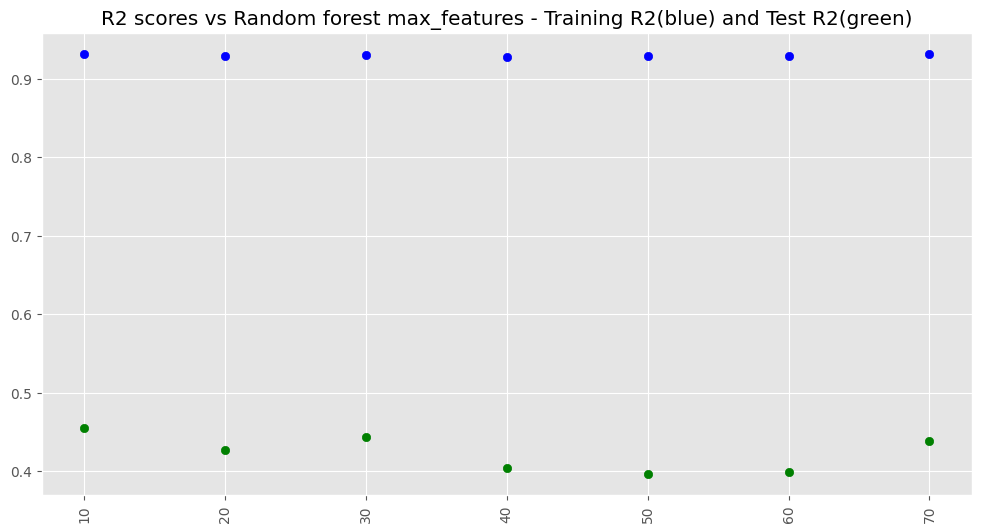

In [23]:
# Scatter plot of R2 scores for training and test datasets as alpha varies
plt.scatter(x=f_metrics_df['features'], y=f_metrics_df['train_r2'], c='blue')
plt.scatter(x=f_metrics_df['features'], y=f_metrics_df['test_r2'], c='green')
plt.xticks(rotation=90)
plt.title('R2 scores vs Random forest max_features - Training R2(blue) and Test R2(green)')
plt.show()

- In all variations, training R2 score indicates overfitting
- The test R2 score however peaks around 0.45 (`max_features` = 60) before stagnating between 0.4 to 0.44

Let's try other tuning another hyper parameters namely `n_estimators`

In [20]:
dt_n_metrics = []
for fcnt in range(10, 150, 10):
    print('-- Random forest with max features : ', fcnt)
    dt_poly_reg_f = RandomForestRegressor(random_state=0, max_features=10, n_estimators=fcnt)
    dt_poly_reg_f.fit(X_poly_train, y_poly_train)

    dt_poly_metrics_f, dt_poly_y_train_pred_f, dt_poly_y_test_pred_f = predict_and_eval(dt_poly_reg_f, X_poly_train, y_poly_train, X_poly_test, y_poly_test)
    dt_poly_metrics_f['estimators'] = fcnt
    dt_n_metrics.append(dt_poly_metrics_f)

-- Random forest with max features :  10
Train Mean Squared Error: 0.09626562231564843
Train R-squared: 0.899839189986356
Test Mean Squared Error: 0.5945819882862435
Test R-squared: 0.47259642671635493
-- Random forest with max features :  20
Train Mean Squared Error: 0.08345529626988316
Train R-squared: 0.9131678591666742
Test Mean Squared Error: 0.5422223364078015
Test R-squared: 0.5190402612767853
-- Random forest with max features :  30
Train Mean Squared Error: 0.07689660260622927
Train R-squared: 0.9199919366948797
Test Mean Squared Error: 0.5567114686368
Test R-squared: 0.5061881731511789
-- Random forest with max features :  40
Train Mean Squared Error: 0.07787177918986912
Train R-squared: 0.9189773016239772
Test Mean Squared Error: 0.5390805808071476
Test R-squared: 0.5218270478979956
-- Random forest with max features :  50
Train Mean Squared Error: 0.07508790000230353
Train R-squared: 0.9218738246786188
Test Mean Squared Error: 0.524581065083843
Test R-squared: 0.53468834634

In [22]:
n_metrics_df = pd.DataFrame(dt_n_metrics)
n_metrics_df.head(10)

,train_mse,train_r2,test_mse,test_r2,estimators
0,0.096266,0.899839,0.594582,0.472596,10
1,0.083455,0.913168,0.542222,0.519040,20
2,0.076897,0.919992,0.556711,0.506188,30
3,0.077872,0.918977,0.539081,0.521827,40
4,0.075088,0.921874,0.524581,0.534688,50
5,0.070663,0.926478,0.554727,0.507948,60
6,0.071342,0.925771,0.548184,0.513752,70
7,0.068963,0.928247,0.562238,0.501286,80
8,0.065285,0.932073,0.602426,0.465639,90
9,0.065929,0.931403,0.614579,0.454859,100


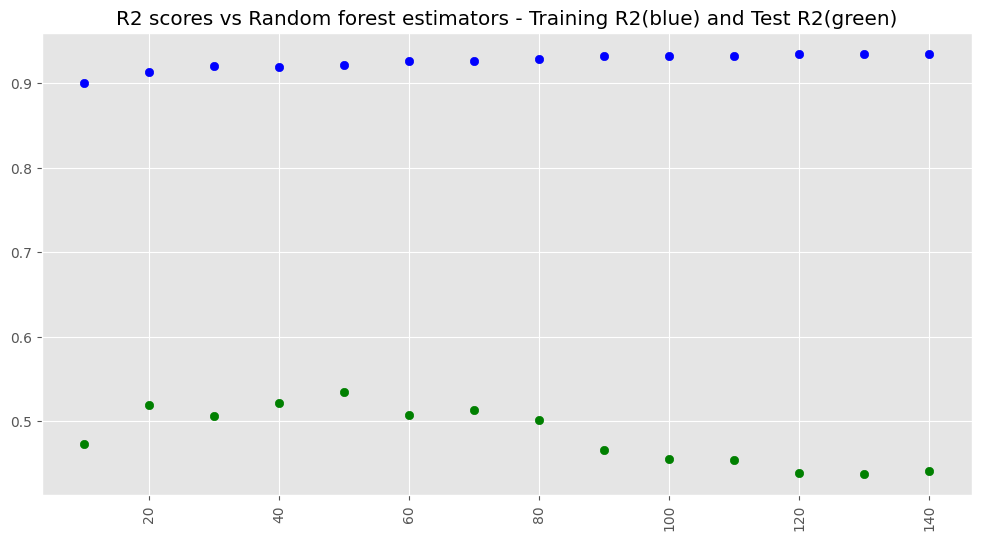

In [24]:
# Scatter plot of R2 scores for training and test datasets as alpha varies
plt.scatter(x=n_metrics_df['estimators'], y=n_metrics_df['train_r2'], c='blue')
plt.scatter(x=n_metrics_df['estimators'], y=n_metrics_df['test_r2'], c='green')
plt.xticks(rotation=90)
plt.title('R2 scores vs Random forest estimators - Training R2(blue) and Test R2(green)')
plt.show()

### Observations
- R2 score for test data peaks around `n_estimators` =50, while training R2 score being always > 90% indicates overfitting
- The test R2 score of 0.53 shows improvement over DecisionTreeRegressor